In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams['axes.facecolor'] = '#f0f4f7'

import csv
import scipy.stats as st
import importlib
import os
import sys
import platform
import qgrid
import datetime
from scipy.interpolate import make_interp_spline, BSpline
import pickle
import random

from scipy.stats import chisquare
from numba import njit

from sync_class import SyncPhenosys
from eda_class import SpikesEDA
from behavior_class import BehaviorAnalysis
from sda_class import SpikesSDA
from report_class import SpikesReport


%load_ext autoreload
%autoreload 2

#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)

%matplotlib notebook
#plt.style.use('ggplot')
#plt.style.use('gadfly.mplstyle')

# %config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import warnings
warnings.filterwarnings('ignore')
# dark theme



# ================================================================================================
# specify file path & sessions

windows_folder = r"C:/Users/User/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
linux_folder = "/home/max/ExpanDrive/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"
mac_folder = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis"

# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[(0,1),(259,'end')]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[(0,1),(276,'end')]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[(271,'end')]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[(184,'end')]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[(307,'end')]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[(0,0),(204,'end')]),
         ]



def load_session(session, missing_rows_ttl=[], lo_spikes=False, deselect_trials=[]):
    # load calss and set folder depending on platform
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder + '/' + session
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder + r"/" + session
    elif platform.system() == 'Darwin':
        folder = mac_folder + r"/" + session
        
    sync_obj = SyncPhenosys(session, folder, 7, 1, missing_rows_ttl) 
    behavior_obj = BehaviorAnalysis(sync_obj, deselect_trials)
    if lo_spikes:
        print(f"{session} -> sda")
        eda_obj = SpikesEDA(behavior_obj)
        sda_obj = SpikesSDA(eda_obj)
        report_obj = SpikesReport(sda_obj)
        session_obj = type('obj', (object,), 
                       {'sync':sync_obj,
                        'behavior':behavior_obj,
                        'eda':eda_obj,
                        'sda': sda_obj,
                        'report': report_obj,
                       })
    else:
        print(f"{session} -> behavior")
        session_obj = type('obj', (object,), 
               {'sync':sync_obj,
                'behavior':behavior_obj,
               })


    return session_obj

# ==========================================================================================
# save & load sessions from pickl functions

# save dict to pickl
def save_all_sessions_dict_pickl(all_sessions_dict):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
    
    for key,value in all_sessions_dict.items():
        file = folder + f"/{key}.pkl"
        with open(file, 'wb') as dump:
            pickle.dump(value, dump, pickle.HIGHEST_PROTOCOL)
            

# load dict from pickl
def load_all_sessions_dict_pickl():
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder
    elif platform.system() == 'Darwin':
        folder = mac_folder 
        
    file = folder + '/all_sessions_dict.pkl'
    with open(file, 'rb') as dump:
        all_sessions_dict = pickle.load(dump)
    return all_sessions_dict



# =======================================================================================
# save figures
def save_fig(name, fig):
    if platform.system() == 'Linux':
        # Linux
        folder = linux_folder+"/figures/all_figures"
    elif platform.system() == 'Windows':
        # windows
        folder = windows_folder+"\figures\all_figures"
    elif platform.system() == 'Darwin':
        folder = mac_folder+"/figures/all_figures"
    try:
        fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')
    except:
        if platform.system() == 'Linux':
            # Linux
            folder = linux_folder+"/figures"
        elif platform.system() == 'Windows':
            # windows
            folder = windows_folder+"\figures"
        elif platform.system() == 'Darwin':
            folder = mac_folder+"/figures"
        fig.savefig(folder+"/"+name+'.png',dpi=200, format='png', bbox_inches='tight')

def convert_numeric(columns, df):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    return df     
    
# =======================================================================================
@njit(fastmath=True)
# binn data
def bin_trial_spike_times_all_cluster(input_ar,nr_bins):
    """binn randm windows from all clusters, all trials all iterations over complete trial

    Args:
        input_ar (np ar): spikes per random event for all clusters, all trials, all iterations
        nr_bins (int): number to bin trial

    Returns:
        np ar: array of binns (i=cluster,j=bin,k=iteration, data=bin count)
    """
    cluster=input_ar.shape[0]
    iterations=input_ar.shape[2]
    # y = cluster index
    # x = bin number 1 to 50
    # z = random iteration 1 to 1000
    data_ar=np.zeros(shape=(cluster,nr_bins,iterations),dtype=int)
    for cl in range(cluster):
        for it in range(iterations):
            data_ar[cl,:,it]=(np.histogram(np.concatenate(input_ar[cl,:,it]).ravel(),bins=nr_bins))[0]
    return data_ar





# Behaviour Analysis

## Tables

In [42]:
def convert_numeric(columns, df):
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    return df

def get_trial_info(all_sessions_dict):
    session_info_df = pd.DataFrame(columns=['id','blocks','tot. trials','wheel ns trials','no resp trials','selected trials',
                                           'reward','no-reward','gamble', 'safe',
                                           'gamble reward','safe reward','gamble no-reward','safe no-reward',
                                           ],
                                  )
    # get individual session objects
    for key,value in all_sessions_dict.items():
        session_name=key
        gamble_side=value.behavior.gamble_side
        missing_rows_ttl=value.sync.rows_missing_ttl
        combined=value.sync.combined_df
        trials=value.sync.all_trials_df
        
        # get info of combined_df
        prop_bin=list((combined['CSV Probability']).dropna().unique())
        # get info form combined
        all_trials = int(combined.index.get_level_values(0).max())
        good_trials = int(combined.index.get_level_values(1).max())
        wheel_ns_trials = all_trials - good_trials
        no_resp_trials = value.behavior.good_trials_df[value.behavior.good_trials_df['event']=='no response in time'].shape[0]
        selected_trials = value.behavior.selected_trials_df.shape[0]
        
        rw=(value.behavior.selected_trials_df["reward_given"]==True).sum()
        norw=(value.behavior.selected_trials_df["reward_given"]==False).sum()
        
        right = (value.behavior.selected_trials_df["right"]==True).sum()
        right_rw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["right"])&(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        right_norw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["right"])&np.invert(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        left = (value.behavior.selected_trials_df["left"]==True).sum()
        left_rw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["left"])&(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        left_norw = (value.behavior.selected_trials_df[(value.behavior.selected_trials_df["left"])&np.invert(value.behavior.selected_trials_df["reward_given"])]).shape[0]
        
        # set safe and gamble side
        if gamble_side=="right":
            gamble=right
            gamble_rw=right_rw
            gamble_norw=right_norw
            safe=left
            safe_rw=left_rw
            safe_norw=left_norw
        elif gamble_side=="left":
            gamble=left
            gamble_rw=left_rw
            gamble_norw=left_norw
            save=right
            save_rw=right_rw    
            save_norw=right_norw

        session_info_df.loc[session_info_df.shape[0] + 1] = [session_name,
                                                             prop_bin,
                                                             all_trials,
                                                             wheel_ns_trials,
                                                             no_resp_trials,
                                                             selected_trials,
                                                             rw,
                                                             norw,
                                                             gamble,
                                                             safe,
                                                             gamble_rw,
                                                             safe_rw,
                                                             gamble_norw,
                                                             safe_norw
                                                             ]
        
        session_info_df = convert_numeric(['tot. trials','wheel ns trials','no resp trials','selected trials',
                                           'reward','no-reward','gamble', 'safe',
                                           'gamble reward','safe reward', 'gamble no-reward', 'safe no-reward'],
                       session_info_df)
        
    return session_info_df


def boxplot_comb(df,columns,scatter=True,title=None):
    fig,ax = plt.subplots()
    session_info_df.boxplot(column=columns,return_type='axes',ax=ax)
    
    if scatter:
        i = 1
        for column in columns:
            y=session_info_df[column] 
            x=np.ones(y.shape[0])*i
            ax.plot(x, y, 'r.', alpha=0.5)
            i+=1
        ax.plot(x,y,'r.',alpha=0.5,label="session")
    ax.set_ylabel('Trial')
    ax.set_title(title)
    ax.legend()

    return fig,ax

import itertools


def boxplot(df,columns,scatter=True,title=None):
    fig,ax = plt.subplots()
    session_info_df.boxplot(column=columns,return_type='axes',ax=ax)

    marker = itertools.cycle(('+', '.', '*')) 

    if scatter:
        for row in df.index:
            y=df.loc[row,columns]
            x=np.arange(1,len(columns)+1)
            ax.plot(x, y, linestyle='',marker = next(marker),label=df.loc[row,'id'],markersize=10 )
    ax.set_ylabel('Trial')
    ax.set_title(title)
    ax.legend()
    return fig,ax


---

In [43]:
sessions_info_df=get_trial_info(all_sessions_dict)
sessions_info_df

,id,blocks,tot. trials,wheel ns trials,no resp trials,selected trials,reward,no-reward,gamble,safe,gamble reward,safe reward,gamble no-reward,safe no-reward
1,JG14_190621,"[0.75, 0.25, 0.125]",569,303,26,208,151,57,82,126,37,114,45,12
2,JG14_190619,"[0.125, 0.25, 0.75]",1143,865,9,257,203,54,88,167,53,150,35,17
3,JG14_190626,"[0.125, 0.25, 0.75]",1297,939,43,274,211,63,73,197,34,177,39,20
4,JG15_190722,"[0.125, 0.25, 0.75]",936,498,58,271,207,64,44,197,15,177,29,20
5,JG15_190725,"[0.75, 0.25, 0.125]",899,427,76,184,113,71,128,56,63,50,65,6
6,JG18a_190814,"[0.125, 0.25, 0.75]",649,250,29,307,234,73,134,56,78,50,56,6
7,JG18b_190828,"[0.75, 0.25, 0.125]",726,352,33,203,150,53,79,124,39,111,40,13


In [44]:
print(session_info_df.to_latex(index=False)) 

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
          id &              blocks &  tot. trials &  wheel ns trials &  no resp trials &  selected trials &  reward &  no-reward &  gamble &  safe &  gamble rewarded &  safe reward &  gamble no-reward &  safe no-reward \\
\midrule
 JG14\_190621 & [0.75, 0.25, 0.125] &          569 &              303 &              26 &              208 &     151 &         57 &      82 &   126 &               37 &          114 &                45 &              12 \\
 JG14\_190619 & [0.125, 0.25, 0.75] &         1143 &              865 &               9 &              257 &     203 &         54 &      88 &   167 &               53 &          150 &                35 &              17 \\
 JG14\_190626 & [0.125, 0.25, 0.75] &         1297 &              939 &              43 &              274 &     211 &         63 &      73 &   197 &               34 &          177 &                39 &              20 \\
 JG15\_190722 & [0.125, 0.25, 0.75] &          936 &       

In [45]:
session = all_sessions_dict['JG14_190621']

session_name=session.sda.session
gamble_side=session.behavior.gamble_side
trials_df=session.behavior.selected_trials_df

In [48]:
trials_df

,start,cue,sound,openloop,reward,iti,end,event,probability,length,select,length_ms,right,left,reward_given,good
0,927792,947831,948491.0,949172.0,957333.0,975474.0,995674.0,right_rw,0.750,67882,True,3394.10,True,False,True,True
1,995938,1015977,1016615.0,1017298.0,1020095.0,1038217.0,1058417.0,right_rw,0.750,62479,True,3123.95,True,False,True,True
2,1058677,1078722,1079379.0,1080059.0,1083302.0,1083459.0,1103660.0,right_norw,0.750,44983,True,2249.15,True,False,False,True
3,1168184,1188225,1188865.0,1189565.0,1194149.0,1212287.0,1232488.0,right_rw,0.750,64304,True,3215.20,True,False,True,True
4,1232750,1252809,1253449.0,1254130.0,1257275.0,1257449.0,1277652.0,right_norw,0.750,44902,True,2245.10,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,15528459,15548517,15549157.0,15549837.0,15567045.0,15570820.0,15591021.0,left_rw,0.125,62562,True,3128.10,False,True,True,True
204,15610327,15630367,15631024.0,15631704.0,15640523.0,15644283.0,15664484.0,left_rw,0.125,54157,True,2707.85,False,True,True,True
205,15664746,15684791,15685446.0,15686127.0,15695328.0,15699106.0,15719307.0,left_rw,0.125,54561,True,2728.05,False,True,True,True
206,15719569,15739613,15740248.0,15740928.0,15742969.0,15743129.0,15763330.0,right_norw,0.125,43761,True,2188.05,True,False,False,True


In [51]:
(trials_df["reward_given"]==False).sum()

57

In [199]:


def create_session_info_df(session):
    session = all_sessions_dict[session]
    info_df = pd.DataFrame(columns=['block','tot. trials','reward','no-reward','gamble', 'safe',
                                    'gamble reward','safe reward', 'gamble no-reward', 'safe no-reward']
                          )

    session_name=session.sda.session
    gamble_side=session.behavior.gamble_side


    # get info of all =============================================
    trials_df=session.behavior.selected_trials_df

    trials = trials_df.shape[0]
    rw=(trials_df["reward_given"]==True).sum()
    norw=(trials_df["reward_given"]==False).sum()
    right = (trials_df["right"]==True).sum()
    right_rw = (trials_df[(trials_df["right"])&(trials_df["reward_given"])]).shape[0]
    right_norw = (trials_df[(trials_df["right"])&np.invert(trials_df["reward_given"])]).shape[0]
    left = (trials_df["left"]==True).sum()
    left_rw = (trials_df[(trials_df["left"])&(trials_df["reward_given"])]).shape[0]
    left_norw = (trials_df[(trials_df["left"])&np.invert(trials_df["reward_given"])]).shape[0]

    # set safe and gamble side
    if gamble_side=="right":
        gamble=right
        gamble_rw=right_rw
        gamble_norw=right_norw
        safe=left
        safe_rw=left_rw
        safe_norw=left_norw
    elif gamble_side=="left":
        gamble=left
        gamble_rw=left_rw
        gamble_norw=left_norw
        save=right
        save_rw=right_rw    
        save_norw=right_norw

    info_df.loc[info_df.shape[0] + 1] = ['all', trials, rw, norw, gamble, safe,gamble_rw,
                                         safe_rw, gamble_norw, safe_norw
                                         ]

    # get info form blocks =============================================
    for block in [0.75,0.25,0.125]:
        block_df = trials_df[trials_df.probability==block]

        trials = block_df.shape[0]
        rw=(block_df["reward_given"]==True).sum()
        norw=(block_df["reward_given"]==False).sum()

        right = (block_df["right"]==True).sum()
        right_rw = (block_df[(trials_df["right"])&(block_df["reward_given"])]).shape[0]
        right_norw = (block_df[(block_df["right"])&np.invert(block_df["reward_given"])]).shape[0]
        left = (block_df["left"]==True).sum()
        left_rw = (block_df[(block_df["left"])&(block_df["reward_given"])]).shape[0]
        left_norw = (block_df[(block_df["left"])&np.invert(block_df["reward_given"])]).shape[0]

        # set safe and gamble side
        if gamble_side=="right":
            gamble=right
            gamble_rw=right_rw
            gamble_norw=right_norw
            safe=left
            safe_rw=left_rw
            safe_norw=left_norw
        elif gamble_side=="left":
            gamble=left
            gamble_rw=left_rw
            gamble_norw=left_norw
            save=right
            save_rw=right_rw    
            save_norw=right_norw

        info_df.loc[info_df.shape[0] + 1] = [block, trials, rw, norw, gamble, safe,gamble_rw,
                                             safe_rw, gamble_norw, safe_norw
                                             ]


    info_df = convert_numeric(['tot. trials','reward','no-reward','gamble', 'safe',
                               'gamble reward','safe reward', 'gamble no-reward', 'safe no-reward'],
                               info_df
                             )
    return info_df

def colormap(info_df):
    from matplotlib.colors import LogNorm
    import copy
    import matplotlib as mpl

    x_labels = info_df.columns.values[1:].tolist()
    y_labels = ['all trials','75% block', "25% block", "12.5% block"]


    data = info_df.loc[:,['tot. trials','reward','no-reward','gamble', 'safe','gamble reward','safe reward', 'gamble no-reward', 'safe no-reward']].values

    fig, ax = plt.subplots()
    #im = ax.imshow(data,norm=LogNorm())

    my_cmap = copy.copy(mpl.cm.get_cmap('viridis')) # copy the default cmap
    my_cmap.set_bad((0,0,0))
    im = ax.imshow(data, 
               norm=mpl.colors.LogNorm(), 
               interpolation='nearest', 
               cmap=my_cmap)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="w")
            text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='black'),
               path_effects.Normal()])

    ax.set_title("Distribution of Trials")
    #fig.colorbar(im)
    fig.tight_layout()
    return fig,ax

In [145]:

JG14_190621_info_df = create_session_info_df('JG14_190621')
JG14_190621_info_df

,block,tot. trials,reward,no-reward,gamble,safe,gamble reward,safe reward,gamble no-reward,safe no-reward
1,all,208,151,57,82,126,37,114,45,12
2,0.750,55,42,13,42,13,31,11,11,2
3,0.250,80,62,18,15,65,3,59,12,6
4,0.125,73,47,26,25,48,3,44,22,4


In [146]:
print(JG14_190621_info_df.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
 block &  tot. trials &  reward &  no-reward &  gamble &  safe &  gamble reward &  safe reward &  gamble no-reward &  safe no-reward \\
\midrule
   all &          208 &     151 &         57 &      82 &   126 &             37 &          114 &                45 &              12 \\
 0.750 &           55 &      42 &         13 &      42 &    13 &             31 &           11 &                11 &               2 \\
 0.250 &           80 &      62 &         18 &      15 &    65 &              3 &           59 &                12 &               6 \\
 0.125 &           73 &      47 &         26 &      25 &    48 &              3 &           44 &                22 &               4 \\
\bottomrule
\end{tabular}



<IPython.core.display.Javascript object>


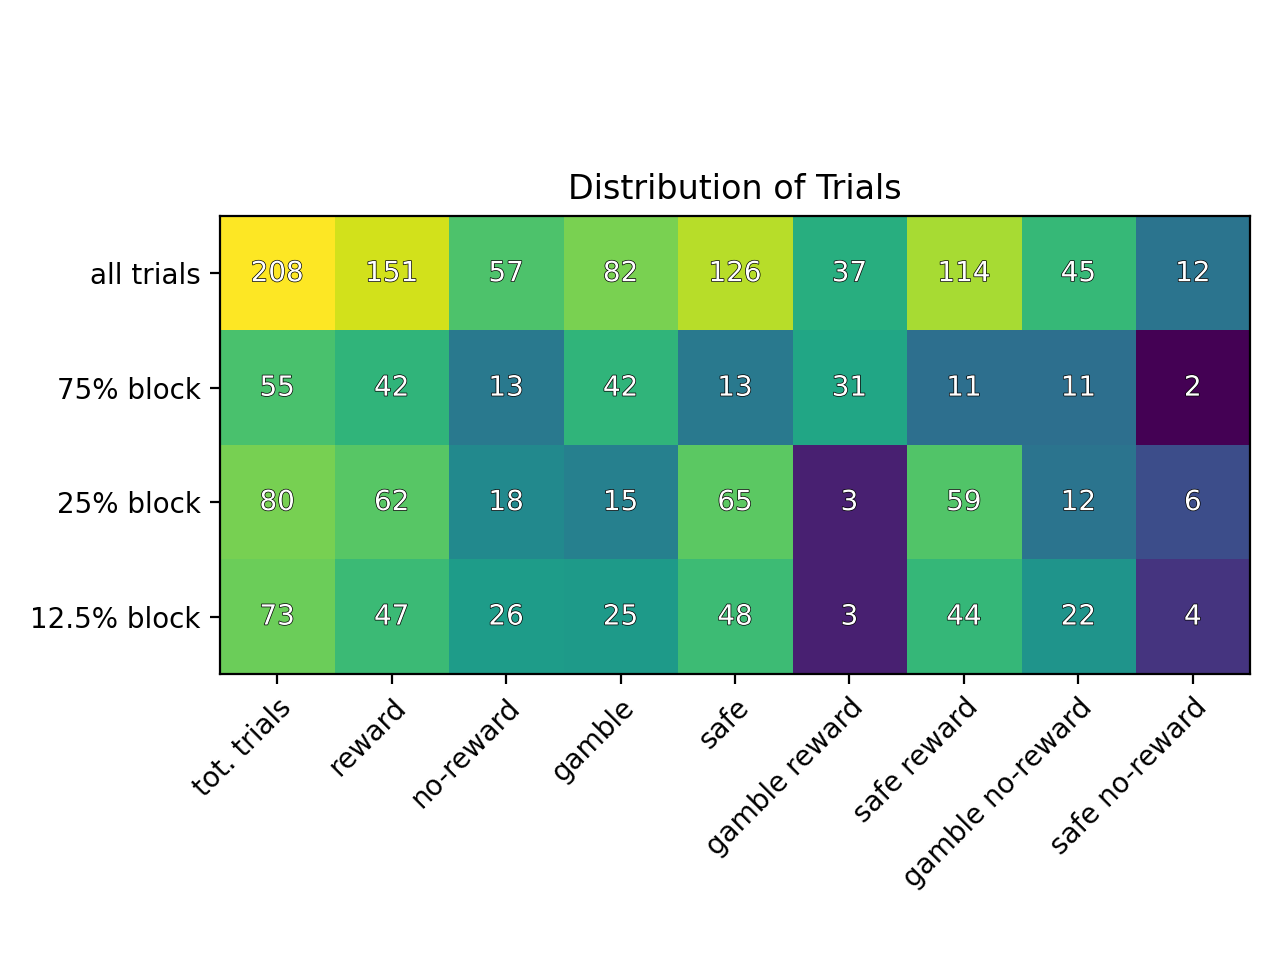

In [200]:
fig,ax=colormap(JG14_190621_info_df)
all_sessions_dict['JG14_190621'].eda.save_fig("colorbar",fig)

In [148]:
JG18b_190828_info_df = create_session_info_df('JG18b_190828')
JG18b_190828_info_df

,block,tot. trials,reward,no-reward,gamble,safe,gamble reward,safe reward,gamble no-reward,safe no-reward
1,all,203,150,53,79,124,39,111,40,13
2,0.750,60,50,10,38,22,30,20,8,2
3,0.250,100,65,35,37,63,9,56,28,7
4,0.125,43,35,8,4,39,0,35,4,4


In [149]:
print(JG18b_190828_indfo_df.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
 block &  trials &  reward &  no-reward &  gamble &  safe &  gamble reward &  safe reward &  gamble no-reward &  safe no-reward \\
\midrule
   all &     203 &     150 &         53 &      79 &   124 &             39 &          111 &                40 &              13 \\
 0.750 &      60 &      50 &         10 &      38 &    22 &             30 &           20 &                 8 &               2 \\
 0.250 &     100 &      65 &         35 &      37 &    63 &              9 &           56 &                28 &               7 \\
 0.125 &      43 &      35 &          8 &       4 &    39 &              0 &           35 &                 4 &               4 \\
\bottomrule
\end{tabular}



<IPython.core.display.Javascript object>


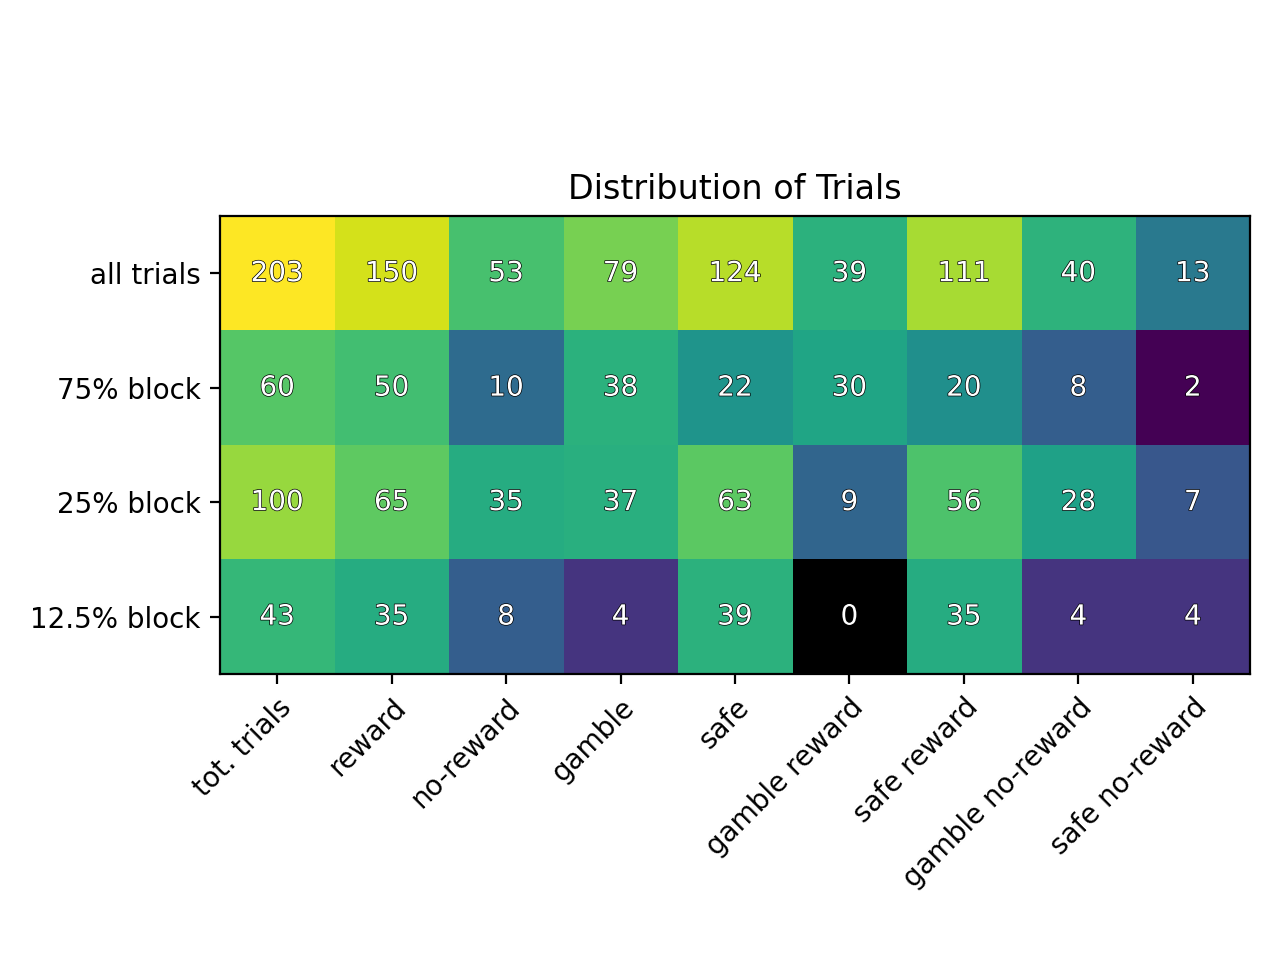

In [201]:
fig,ax=colormap(JG18b_190828_info_df)
all_sessions_dict['JG18b_190828'].eda.save_fig("colorbar",fig)

## Plots

**Box Plots Summaries**

In [294]:
# wheel not stop vs other
fig,ax = boxplot(session_info_df,['tot. trials','wheel ns trials','no resp trials','selected trials' ],True)
save_fig("boxplot_whell_ns", fig)

# gamble vs save
fig,ax = boxplot(session_info_df,['no resp trials','gamble','safe'],True)
save_fig("boxplot_gamble_safe", fig)

# reward vs no-reward

fig,ax = boxplot(session_info_df,['reward','no-reward'],True)
save_fig("boxplot_rw_norw", fig)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [290]:
session_info_df['reward no-reward ratio'] = (session_info_df['reward'] / session_info_df['no-reward'])
session_info_df['gamble safe-side ratio'] = (session_info_df['gamble'] / session_info_df['safe'])

fig,ax = boxplot(session_info_df,['reward no-reward ratio','gamble safe-side ratio'],True)
save_fig("boxplot_ratio", fig)

<IPython.core.display.Javascript object>

In [182]:
 session_info_df

,Session,Gambl Side,prop bins,Trials,tot. Trials,wheel ns,no resp,gamble chosen,gamble rewarded,safe chosen,safe rewarded,chosen,rewarded,not rewarded,reward ratio,reward no-reward ratio
1,JG14_190621,right,"[0.75, 0.25, 0.125]",266,569,303,26,101,42,140,126,241,168,73,2.301370,2.301370
2,JG14_190619,right,"[0.125, 0.25, 0.75]",278,1143,865,9,94,57,176,159,270,216,54,4.000000,4.000000
3,JG14_190626,right,"[0.125, 0.25, 0.75]",358,1297,939,43,111,63,205,185,316,248,68,3.647059,3.647059
4,JG15_190722,left,"[0.125, 0.25, 0.75]",438,936,498,58,133,82,248,223,381,305,76,4.013158,4.013158
5,JG15_190725,right,"[0.75, 0.25, 0.125]",472,899,427,76,139,64,258,232,397,296,101,2.930693,2.930693
6,JG18a_190814,left,"[0.125, 0.25, 0.75]",399,649,250,29,183,114,188,169,371,283,88,3.215909,3.215909
7,JG18b_190828,right,"[0.75, 0.25, 0.125]",374,726,352,33,109,43,233,209,342,252,90,2.800000,2.800000


In [135]:

ratio = (session_info_df['rewarded'] / session_info_df['not rewarded'])
ratio = ratio/(ratio.max()-ratio.min())
ratio_norm = (ratio-ratio.mean())/ratio.std()
ratio_norm
#session_info_df['rewarded ratio'] = (session_info_df['chosen'] - session_info_df['rewarded'])


#boxplot(session_info_df,['rewarded ratio'],True)

1   -1.503266
2    1.125871
3    0.579589
4    1.146237
5   -0.529200
6   -0.087744
7   -0.731487
dtype: float64

In [136]:
ratio/(ratio.max()-ratio.min())

1    1.344425
2    2.336738
3    2.130555
4    2.344425
5    1.712065
6    1.878684
7    1.635717
dtype: float64

In [137]:
ratio.max()-ratio.min()

0.9999999999999998

In [138]:
ratio = (session_info_df['rewarded'] / session_info_df['not rewarded'])

plt.figure()
plt.hist(ratio)

<IPython.core.display.Javascript object>

(array([1., 0., 1., 1., 0., 1., 0., 1., 0., 2.]),
 array([2.30136986, 2.47254867, 2.64372747, 2.81490627, 2.98608508,
        3.15726388, 3.32844268, 3.49962149, 3.67080029, 3.84197909,
        4.01315789]),
 <BarContainer object of 10 artists>)

---

## Chi Square Blocks

In [10]:
count_df = pd.DataFrame(columns=["session","block","gamble","safe"])

for session in se_li: 
    session=session[0]
    trials = all_sessions_dict[session].behavior.selected_trials_df
    blocks = trials['probability'].unique()
    gamble_side = all_sessions_dict[session].behavior.gamble_side

    #blocks = all_sessions_dict['JG14_190621'].behavior.selected_trials_df['probability'].unique()
    
    for block in [0.75,0.25,0.125]:
        df = trials.loc[trials["probability"]==block,"event"]
        right_count = (df=="right_rw").sum()+(df=="right").sum()
        left_count = (df=="left_rw").sum()+(df=="left").sum()
        if gamble_side == 'right':
            gamble_count = right_count
            safe_count = left_count
        elif gamble_side == 'left':
            gamble_count = left_count
            safe_count = right_count
        # add to df
        count_df.loc[count_df.shape[0] + 1] = [session,block,gamble_count,safe_count]

count_df

,session,block,gamble,safe
1,JG14_190621,0.750,31,11
2,JG14_190621,0.250,3,59
3,JG14_190621,0.125,3,44
4,JG14_190619,0.750,49,35
5,JG14_190619,0.250,2,58
6,JG14_190619,0.125,2,57
7,JG14_190626,0.750,29,55
8,JG14_190626,0.250,3,58
9,JG14_190626,0.125,2,64
10,JG15_190722,0.750,9,49


In [60]:
file = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/1 Data Analysis/all_session_sides.xlsx"
count_df.to_excel(file, index = False)

In [11]:
all_crosstables_dict=dict()

# create contigency table for all session
crosstable_df_all = pd.DataFrame(columns=["block","gamble","safe"])
crosstable_df_all.loc[crosstable_df_all.shape[0] + 1] = [0.75]+count_df.loc[count_df["block"]==0.75,["gamble","safe"]].sum(axis=0).values.tolist()
crosstable_df_all.loc[crosstable_df_all.shape[0] + 1] = [0.25]+count_df.loc[count_df["block"]==0.25,["gamble","safe"]].sum(axis=0).values.tolist()
crosstable_df_all.loc[crosstable_df_all.shape[0] + 1] = [0.125]+count_df.loc[count_df["block"]==0.125,["gamble","safe"]].sum(axis=0).values.tolist()

all_crosstables_dict['all']=crosstable_df_all

for session in se_li:
    session=session[0]
    crosstable_df = pd.DataFrame(columns=["block","gamble","safe"])
    df = count_df[count_df['session']==session]
    crosstable_df.loc[crosstable_df.shape[0] + 1] = [0.75]+df.loc[df["block"]==0.75,["gamble","safe"]].sum(axis=0).values.tolist()
    crosstable_df.loc[crosstable_df.shape[0] + 1] = [0.25]+df.loc[df["block"]==0.25,["gamble","safe"]].sum(axis=0).values.tolist()
    crosstable_df.loc[crosstable_df.shape[0] + 1] = [0.125]+df.loc[df["block"]==0.125,["gamble","safe"]].sum(axis=0).values.tolist()

    all_crosstables_dict[session]=crosstable_df

In [12]:
all_crosstables_dict['JG18b_190828']

,block,gamble,safe
1,0.750,30.0,20.0
2,0.250,9.0,56.0
3,0.125,0.0,35.0


In [71]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

for session,crosstable in all_crosstables_dict.items():

    stat, p, dof, expected = chi2_contingency(crosstable)
    #stat, p = chisquare(test_ar)
    #dof = 1

    print(session)
    print("-----------")

    print('dof=%d\n' % dof)
    print(expected)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('\nprobability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('\nsignificance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
    print("-----------------------------------------\n")

all
-----------
dof=4

[[4.35562445e-01 1.23506151e+02 3.67808287e+02]
 [3.89061116e-01 1.10320441e+02 3.28540498e+02]
 [3.00376439e-01 8.51734081e+01 2.53651215e+02]]

probability=0.950, critical=9.488, stat=353.803
Dependent (reject H0)

significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------------

JG14_190621
-----------
dof=4

[[ 0.31614626 10.39769926 32.03615448]
 [ 0.46035333 15.14050945 46.64913722]
 [ 0.34850041 11.46179129 35.3147083 ]]

probability=0.950, critical=9.488, stat=76.858
Dependent (reject H0)

significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------------

JG14_190619
-----------
dof=4

[[ 0.46708512 22.00489896 62.27801592]
 [ 0.33205756 15.64360073 44.2743417 ]
 [ 0.32585732 15.35150031 43.44764238]]

probability=0.950, critical=9.488, stat=77.374
Dependent (reject H0)

significance=0.050, p=0.000
Dependent (reject H0)
-----------------------------------------

JG14_190626
-----------
dof=4

[[ 0.44946

In [85]:
for row in crosstable.iterrows():
    row

In [92]:
row[1].values[1:]

array([ 0., 35.])

In [13]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

dep_indep_df=pd.DataFrame(columns=["session","block","dep","stat","dof","critical"])

for session,crosstable in all_crosstables_dict.items():
    # compare all blocks
    stat, p, dof, expected = chi2_contingency(crosstable)
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    if abs(stat) >= critical:
        dep='dependent'
    else:
        dep='independent'
    dep_indep_df.loc[dep_indep_df.shape[0] + 1] = [session,'all',dep,stat,dof,critical]
    
    for row in crosstable.iterrows():
        stat, p = chisquare(row[1].values[1:])
        dof = 1
        prob = 0.95
        critical = chi2.ppf(prob, dof)
        if abs(stat) >= critical:
            dep='dependent'
        else:
            dep='independent'
        dep_indep_df.loc[dep_indep_df.shape[0] + 1] = [session,row[1].values[0],dep,stat,dof,critical]
                                                        
dep_indep_df

,session,block,dep,stat,dof,critical
1,all,all,dependent,353.802895,4,9.487729
2,all,0.750,independent,2.788187,1,3.841459
3,all,0.250,dependent,280.640091,1,3.841459
4,all,0.125,dependent,296.427729,1,3.841459
5,JG14_190621,all,dependent,76.858002,4,9.487729
6,JG14_190621,0.750,dependent,9.523810,1,3.841459
7,JG14_190621,0.250,dependent,50.580645,1,3.841459
8,JG14_190621,0.125,dependent,35.765957,1,3.841459
9,JG14_190619,all,dependent,77.374097,4,9.487729
10,JG14_190619,0.750,independent,2.333333,1,3.841459


In [14]:
dep_indep_df.loc[dep_indep_df.session=='all',["block","dep","stat","dof"]]

,block,dep,stat,dof
1,all,dependent,353.802895,4
2,0.750,independent,2.788187,1
3,0.250,dependent,280.640091,1
4,0.125,dependent,296.427729,1


In [106]:
print(dep_indep_df.loc[dep_indep_df.session=='all',["block","dep","stat","dof"]].to_latex(index=False))

\begin{tabular}{llrl}
\toprule
 block &         dep &       stat & dof \\
\midrule
   all &   dependent & 353.802895 &   4 \\
 0.750 & independent &   2.788187 &   1 \\
 0.250 &   dependent & 280.640091 &   1 \\
 0.125 &   dependent & 296.427729 &   1 \\
\bottomrule
\end{tabular}



In [34]:
indep = dep_indep_df.loc[np.logical_and(np.logical_or(dep_indep_df.session=="JG18b_190828", dep_indep_df.session=="JG14_190619"),dep_indep_df.block==0.75),:]
print(indep.to_latex(index=False))

\begin{tabular}{lllrlr}
\toprule
     session & block &         dep &     stat & dof &  critical \\
\midrule
 JG14\_190619 &  0.75 & independent & 2.333333 &   1 &  3.841459 \\
JG18b\_190828 &  0.75 & independent & 2.000000 &   1 &  3.841459 \\
\bottomrule
\end{tabular}



In [35]:
indep

,session,block,dep,stat,dof,critical
10,JG14_190619,0.75,independent,2.333333,1,3.841459
30,JG18b_190828,0.75,independent,2.000000,1,3.841459
